# Advanced Anomaly Detection Models for CTA Transit Data

This notebook builds supervised machine learning models for anomaly detection using the features from our EDA analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import mlflow
import mlflow.sklearn
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure matplotlib
plt.rcParams.update({
    "font.family": "serif",
    "figure.figsize": (12, 8),
    "axes.grid": True,
    "grid.alpha": 0.3
})

# Set pandas display options
pd.set_option('display.max_columns', 50)

## 1. Data Loading and Feature Engineering

In [3]:
# Load data from database
DB_PATH = '../../data/cta_database.db'
conn = sqlite3.connect(DB_PATH)
query = "SELECT * FROM train_positions"
df = pd.read_sql_query(query, conn)
conn.close()

print(f"Loaded {len(df):,} records from database")

Loaded 10,746 records from database


In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on earth (in km)"""
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c  # Earth radius in km

# Sort by train and timestamp
df_sorted = df.sort_values(['run_number', 'fetch_timestamp']).copy()

# Calculate speed
df_sorted['prev_lat'] = df_sorted.groupby('run_number')['latitude'].shift(1)
df_sorted['prev_lon'] = df_sorted.groupby('run_number')['longitude'].shift(1)
df_sorted['prev_timestamp'] = df_sorted.groupby('run_number')['fetch_timestamp'].shift(1)

mask = df_sorted[['prev_lat', 'prev_lon', 'prev_timestamp']].notna().all(axis=1)
df_sorted.loc[mask, 'distance_km'] = df_sorted.loc[mask].apply(
    lambda row: haversine_distance(row['prev_lat'], row['prev_lon'], row['latitude'], row['longitude']), axis=1
)
df_sorted.loc[mask, 'time_diff_hours'] = (df_sorted.loc[mask, 'fetch_timestamp'] - df_sorted.loc[mask, 'prev_timestamp']) / 3600
df_sorted.loc[mask, 'speed_kmh'] = df_sorted.loc[mask, 'distance_km'] / df_sorted.loc[mask, 'time_diff_hours']
df_sorted.loc[df_sorted['time_diff_hours'] == 0, 'speed_kmh'] = 0

# Add time features
df_sorted['datetime'] = pd.to_datetime(df_sorted['fetch_timestamp'], unit='s')
df_sorted['hour_of_day'] = df_sorted['datetime'].dt.hour
df_sorted['day_of_week'] = df_sorted['datetime'].dt.dayofweek
df_sorted['is_weekend'] = df_sorted['day_of_week'].isin([5, 6])
df_sorted['is_rush_hour'] = df_sorted['hour_of_day'].isin([7, 8, 9, 17, 18, 19])

print(f"Feature engineering complete. Records with speed: {df_sorted['speed_kmh'].notna().sum():,}")

Feature engineering complete. Records with speed: 10,568


## 2. Create Anomaly Labels

In [5]:
# Select records with valid speed data
df_features = df_sorted[df_sorted['speed_kmh'].notna()].copy()

# Prepare features for anomaly detection
feature_cols = ['speed_kmh', 'hour_of_day', 'day_of_week', 'is_delayed', 'heading', 'latitude', 'longitude']
X_unsupervised = df_features[feature_cols].fillna(df_features[feature_cols].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

# Method 1: Z-score anomalies
def detect_zscore_anomalies(group, threshold=2.5):
    if len(group) < 3:
        return pd.Series([False] * len(group), index=group.index)
    z_scores = np.abs(stats.zscore(group['speed_kmh'].fillna(group['speed_kmh'].median())))
    return z_scores > threshold

df_features['zscore_anomaly'] = df_features.groupby(['route_name', 'hour_of_day']).apply(
    detect_zscore_anomalies
).reset_index(level=[0,1], drop=True)

# Method 2: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
df_features['iso_anomaly'] = iso_forest.fit_predict(X_scaled) == -1

# Create ensemble labels
methods = ['zscore_anomaly', 'iso_anomaly']
df_features['ensemble_anomaly'] = (df_features[methods].sum(axis=1) >= 1)

anomaly_count = df_features['ensemble_anomaly'].sum()
anomaly_rate = df_features['ensemble_anomaly'].mean()

print(f"Total anomalies: {anomaly_count:,} ({anomaly_rate:.2%})")
print(f"Normal samples: {len(df_features) - anomaly_count:,}")

Total anomalies: 529 (5.01%)
Normal samples: 10,039


## 3. Data Preparation

In [6]:
# Prepare features for supervised learning
modeling_features = [
    'speed_kmh', 'hour_of_day', 'day_of_week', 'is_delayed', 'heading',
    'latitude', 'longitude', 'is_weekend', 'is_rush_hour'
]

X = df_features[modeling_features].copy()
y = df_features['ensemble_anomaly'].astype(int)

# Handle missing values
X = X.fillna(X.median())

# Encode route names
le_route = LabelEncoder()
X['route_encoded'] = le_route.fit_transform(df_features['route_name'])
modeling_features.append('route_encoded')

# Time-based split
split_idx = int(len(X) * 0.7)
val_split_idx = int(len(X) * 0.85)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_val = X.iloc[split_idx:val_split_idx]
y_val = y.iloc[split_idx:val_split_idx]
X_test = X.iloc[val_split_idx:]
y_test = y.iloc[val_split_idx:]

print(f"Training: {len(X_train):,} samples ({y_train.mean():.2%} anomalies)")
print(f"Validation: {len(X_val):,} samples ({y_val.mean():.2%} anomalies)")
print(f"Test: {len(X_test):,} samples ({y_test.mean():.2%} anomalies)")

Training: 7,397 samples (5.64% anomalies)
Validation: 1,585 samples (1.58% anomalies)
Test: 1,586 samples (5.49% anomalies)


## 4. Model Training

In [7]:
# Setup MLflow
mlflow.set_experiment("CTA Anomaly Detection")

def evaluate_model(model, X_val, y_val, model_name):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    auc_roc = roc_auc_score(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)
    
    print(f"\n=== {model_name} RESULTS ===")
    print(f"AUC-ROC: {auc_roc:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(classification_report(y_val, y_pred))
    
    return {
        'auc_roc': auc_roc,
        'avg_precision': avg_precision,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

print("MLflow setup complete")

MLflow setup complete


### 4.1 LightGBM

In [8]:
# Model 1: LightGBM
with mlflow.start_run(run_name="LightGBM_Anomaly_Detection"):
    lgb_model = lgb.LGBMClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        class_weight='balanced'
    )
    
    lgb_model.fit(X_train[modeling_features], y_train)
    lgb_results = evaluate_model(lgb_model, X_val[modeling_features], y_val, "LightGBM")
    
    # Log to MLflow
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_metric("auc_roc", lgb_results['auc_roc'])
    mlflow.log_metric("avg_precision", lgb_results['avg_precision'])
    
    mlflow.sklearn.log_model(
        lgb_model,
        "lightgbm_anomaly_model",
        input_example=X_train[modeling_features].head(1)
    )

[LightGBM] [Info] Number of positive: 417, number of negative: 6980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 7397, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

2025/09/02 17:22:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### 4.2 Random Forest

In [9]:
# Model 2: Random Forest
with mlflow.start_run(run_name="RandomForest_Anomaly_Detection"):
    rf_model = RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        class_weight='balanced'
    )
    
    rf_model.fit(X_train[modeling_features], y_train)
    rf_results = evaluate_model(rf_model, X_val[modeling_features], y_val, "Random Forest")
    
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_metric("auc_roc", rf_results['auc_roc'])
    mlflow.log_metric("avg_precision", rf_results['avg_precision'])
    
    mlflow.sklearn.log_model(
        rf_model,
        "random_forest_anomaly_model",
        input_example=X_train[modeling_features].head(1)
    )

2025/09/02 17:22:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Random Forest RESULTS ===
AUC-ROC: 0.975
Average Precision: 0.924
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      0.72      0.84        25

    accuracy                           1.00      1585
   macro avg       1.00      0.86      0.92      1585
weighted avg       1.00      1.00      1.00      1585



### 4.3 Logistic Regression

In [10]:
# Model 3: Logistic Regression
with mlflow.start_run(run_name="LogisticRegression_Anomaly_Detection"):
    scaler_lr = StandardScaler()
    lr_model = LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000
    )
    
    lr_pipeline = Pipeline([
        ('scaler', scaler_lr),
        ('classifier', lr_model)
    ])
    
    lr_pipeline.fit(X_train[modeling_features], y_train)
    lr_results = evaluate_model(lr_pipeline, X_val[modeling_features], y_val, "Logistic Regression")
    
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("auc_roc", lr_results['auc_roc'])
    mlflow.log_metric("avg_precision", lr_results['avg_precision'])
    
    mlflow.sklearn.log_model(
        lr_pipeline,
        "logistic_regression_anomaly_model",
        input_example=X_train[modeling_features].head(1)
    )

2025/09/02 17:22:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



=== Logistic Regression RESULTS ===
AUC-ROC: 0.953
Average Precision: 0.733
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1560
           1       0.23      0.80      0.36        25

    accuracy                           0.96      1585
   macro avg       0.61      0.88      0.67      1585
weighted avg       0.98      0.96      0.97      1585



## 5. Model Comparison

In [11]:
# Compare models
results_comparison = pd.DataFrame({
    'Model': ['LightGBM', 'Random Forest', 'Logistic Regression'],
    'AUC-ROC': [lgb_results['auc_roc'], rf_results['auc_roc'], lr_results['auc_roc']],
    'Avg Precision': [lgb_results['avg_precision'], rf_results['avg_precision'], lr_results['avg_precision']]
})

print("\n=== MODEL COMPARISON ===")
print(results_comparison.round(3))

# Select best model
best_idx = results_comparison['AUC-ROC'].idxmax()
best_model_name = results_comparison.loc[best_idx, 'Model']
best_auc = results_comparison.loc[best_idx, 'AUC-ROC']

print(f"\nBest model: {best_model_name} (AUC-ROC: {best_auc:.3f})")

if best_model_name == 'LightGBM':
    best_model = lgb_model
    best_results = lgb_results
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_results = rf_results
else:
    best_model = lr_pipeline
    best_results = lr_results


=== MODEL COMPARISON ===
                 Model  AUC-ROC  Avg Precision
0             LightGBM    0.996          0.927
1        Random Forest    0.975          0.924
2  Logistic Regression    0.953          0.733

Best model: LightGBM (AUC-ROC: 0.996)


## 6. Final Evaluation

In [12]:
# Final evaluation on test set
print(f"\n=== FINAL EVALUATION: {best_model_name} ===")
test_results = evaluate_model(best_model, X_test[modeling_features], y_test, f"{best_model_name} (Test Set)")

# Confusion matrix
cm = confusion_matrix(y_test, test_results['predictions'])
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives: {cm[1,1]:,}")

# Calculate metrics
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAnomaly Detection Performance:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")


=== FINAL EVALUATION: LightGBM ===

=== LightGBM (Test Set) RESULTS ===
AUC-ROC: 0.988
Average Precision: 0.873
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1499
           1       0.82      0.68      0.74        87

    accuracy                           0.97      1586
   macro avg       0.90      0.83      0.86      1586
weighted avg       0.97      0.97      0.97      1586


Confusion Matrix:
True Negatives: 1,486
False Positives: 13
False Negatives: 28
True Positives: 59

Anomaly Detection Performance:
Precision: 0.819
Recall: 0.678
F1-Score: 0.742


## 7. Feature Importance


=== FEATURE IMPORTANCE (LightGBM) ===
         feature  importance
0      speed_kmh         765
6      longitude         540
5       latitude         536
4        heading         414
1    hour_of_day         291
3     is_delayed         144
9  route_encoded          39
2    day_of_week          23
8   is_rush_hour          12
7     is_weekend           0


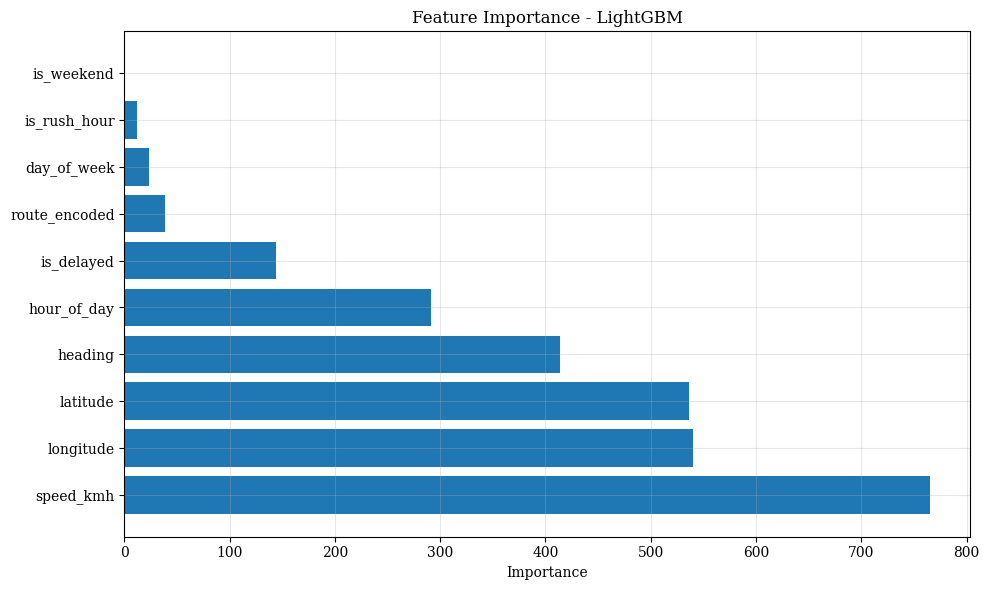


Top 3 features: ['speed_kmh', 'longitude', 'latitude']


In [13]:
# Feature importance analysis
if best_model_name in ['LightGBM', 'Random Forest']:
    if best_model_name == 'LightGBM':
        importances = lgb_model.feature_importances_
    else:
        importances = rf_model.feature_importances_
    
    feature_importance = pd.DataFrame({
        'feature': modeling_features,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\n=== FEATURE IMPORTANCE ({best_model_name}) ===")
    print(feature_importance.round(4))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    top_features = feature_importance.head(3)['feature'].tolist()
    print(f"\nTop 3 features: {top_features}")
else:
    print(f"Feature importance not available for {best_model_name}")

## 8. Save Model for Deployment

In [14]:
# Save the best model
import joblib
import os

os.makedirs('models', exist_ok=True)

model_artifacts = {
    'model': best_model,
    'features': modeling_features,
    'label_encoder': le_route,
    'performance': {
        'auc_roc': test_results['auc_roc'],
        'avg_precision': test_results['avg_precision'],
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
}

joblib.dump(model_artifacts, 'models/best_anomaly_model.pkl')
print("\nModel saved to 'models/best_anomaly_model.pkl'")
print("Ready for FastAPI deployment!")

print(f"\n=== SUMMARY ===")
print(f"Best model: {best_model_name}")
print(f"Test AUC-ROC: {test_results['auc_roc']:.3f}")
print(f"Test Precision: {precision:.3f}")
print(f"Test Recall: {recall:.3f}")


Model saved to 'models/best_anomaly_model.pkl'
Ready for FastAPI deployment!

=== SUMMARY ===
Best model: LightGBM
Test AUC-ROC: 0.988
Test Precision: 0.819
Test Recall: 0.678
